In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [2]:
torch.manual_seed(0)

In [3]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

## Generate Dataset

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


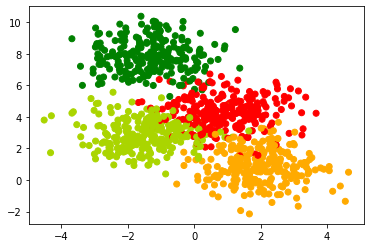

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


## Using torch tensors and autograd

In [7]:
X_train, Y_train, X_val, Y_val = map(torch.tensor, [X_train, Y_train, X_val, Y_val])

In [8]:
print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [9]:
a = torch.rand([2,4])
print(a)
print(a.exp())
# Difference in sum!
print("Summing Along different Axis")
print(a.exp().sum())
print(a.exp().sum(0)) # Sum Along Columns
print(a.exp().sum(-1)) # Sum Along Rows
print(a.exp().sum(1)) # Totally 2 rows present here

tensor([[0.4963, 0.7682, 0.0885, 0.1320],
        [0.3074, 0.6341, 0.4901, 0.8964]])
tensor([[1.6426, 2.1559, 1.0925, 1.1411],
        [1.3599, 1.8853, 1.6325, 2.4509]])
Summing Along different Axis
tensor(13.3607)
tensor([3.0025, 4.0412, 2.7250, 3.5920])
tensor([6.0321, 7.3285])
tensor([6.0321, 7.3285])


In [10]:
print(a.exp().sum(-1).unsqueeze(-1)) # We want N rows and 1 column
print(a.exp() / (a.exp().sum(-1).unsqueeze(-1)) )

tensor([[6.0321],
        [7.3285]])
tensor([[0.2723, 0.3574, 0.1811, 0.1892],
        [0.1856, 0.2573, 0.2228, 0.3344]])


In [11]:
y_hat = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.8, 0.1, 0.05, 0.05]])
y = torch.tensor([2, 0])

y_hat[range(y_hat.shape[0]), y] # Select each row of y_hat and take the value given by y.

tensor([0.3000, 0.8000])

In [12]:
-y_hat[range(y_hat.shape[0]), y].log()

tensor([1.2040, 0.2231])

In [13]:
-y_hat[range(y_hat.shape[0]), y].log().mean() # CE loss

tensor(0.7136)

Finding the Accuracy

In [14]:
torch.argmax(y_hat, dim = -1)               # Finds the largest value and gives the dimension along the columns(-1) dimension.
(torch.argmax(y_hat, dim = -1) == y)        # tensor([False,  True])
(torch.argmax(y_hat, dim = -1) == y).float().mean()

tensor(0.5000)

In [15]:
(torch.argmax(y_hat, dim = -1) == y)

tensor([False,  True])

In [16]:
def model(x):                                   #(Rows, Columns of input) * (Input Neurons, Neuron in the Present Layer)
    a1 = torch.matmul(x, weights1) + bias1      # (N, 2) X (2, 2) -> (N,2)
    h1 = a1.sigmoid()
    a2 = torch.matmul(h1, weights2) + bias2     # (N, 2) x (2, 4) -> (N, 4)
    h2 = a2.exp() / a2.exp().sum(-1).unsqueeze(-1) # Sum along the last dimension and unsqueeze to contain n,1 dimension from n dimension.
    return h2

In [17]:
def loss_fn(y_hat, y):
  return -(y_hat[range(y.shape[0]), y].log()).mean()

In [18]:
def accuracy(y_hat, y):
    pred = torch.argmax(y_hat, dim = -1)
    return ( pred == y ).float().mean()

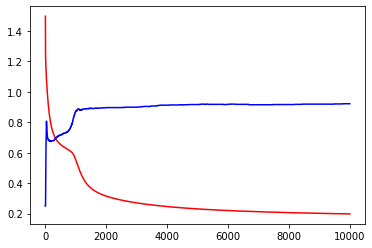

Loss before training 1.4956300258636475
Loss after training 0.19809019565582275


In [19]:
torch.manual_seed(0)
weights1 = torch.rand(2,2) / math.sqrt(2)   # Xavier Initialisation dividing by the total input neurons.
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float() 
Y_train = Y_train.long() # Used in loop so converted to long

loss_arr = []
acc_arr = []

for epoch in range(epochs):
    y_hat = model(X_train)
    loss = loss_fn(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train)) 
    loss.backward()

    with torch.no_grad():
        weights1 -= weights1.grad * learning_rate
        bias1 -= bias1.grad * learning_rate
        weights2 -= weights2.grad * learning_rate
        bias2 -= bias2.grad * learning_rate
        weights1.grad.zero_()
        bias1.grad.zero_()
        weights2.grad.zero_()
        bias2.grad.zero_()

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

# Using NN.Functional

In [20]:
import torch.nn.functional as F

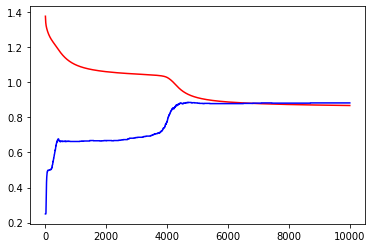

Loss before training 1.3771817684173584
Loss after training 0.8678802251815796


In [21]:
torch.manual_seed(0)
weights1 = torch.rand(2,2) / math.sqrt(2)   # Xavier Initialisation dividing by the total input neurons.
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float() 
Y_train = Y_train.long() # Used in loop so converted to long

loss_arr = []
acc_arr = []

for epoch in range(epochs):
    y_hat = model(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train)) 
    loss.backward()

    with torch.no_grad():
        weights1 -= weights1.grad * learning_rate
        bias1 -= bias1.grad * learning_rate
        weights2 -= weights2.grad * learning_rate
        bias2 -= bias2.grad * learning_rate
        weights1.grad.zero_()
        bias1.grad.zero_()
        weights2.grad.zero_()
        bias2.grad.zero_()

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

# Using NN Parameter

Used to attach variables to paramters.

In [22]:
import torch.nn as nn

In [23]:
class FirstNetwork(nn.Module):

    def __init__(self):
        super().__init__()       # Calling init function of nn.Module
        torch.manual_seed(0)
        self.weights1 = nn.Parameter( torch.randn(2, 2) / math.sqrt(2) )
        self.bias1 = nn.Parameter( torch.zeros(2) )
        self.weights2 = nn.Parameter( torch.randn(2, 4) / math.sqrt(2) )
        self.bias2 = nn.Parameter( torch.zeros(4) )
    
    def forward(self, X):
        a1 = torch.matmul(X, self.weights1) + self.bias1
        h1 = a1.sigmoid()
        a2 = torch.matmul(h1, self.weights2) + self.bias2
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

In [24]:
def fit(epochs = 100, learning_rate = 1):
    loss_arr = []
    acc_arr = []

    for epoch in range(epochs):
        y_hat = fn(X_train)         # fn() will execute the forward function in FirstNetwork Class.
        loss = F.cross_entropy(y_hat, Y_train)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, Y_train)) 
        loss.backward()

        with torch.no_grad():
            for param in fn.parameters():       # For all the parameters present in fn Model.
                param -= learning_rate * param.grad
            fn.zero_grad()
            
    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

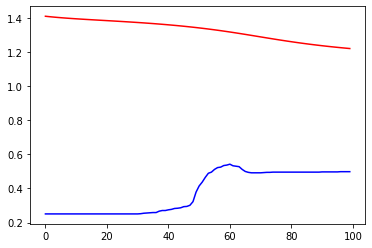

Loss before training 1.4111980199813843
Loss after training 1.2216507196426392


In [25]:
fn = FirstNetwork()
fit()

# Using NN.Linear and Optim

NN.Linear is for abstraction instead of writing the same code repeatedly for eg Matrix multiplication in A1, A2.

In [26]:
class FirstNetwork_v1(nn.Module):

    def __init__(self):
        super().__init__()       # Calling init function of nn.Module
        torch.manual_seed(0)
        self.lin1 = nn.Linear(2,2)      # (2 input neurons, 2 output neurons)   -> First Layer
        self.lin2 = nn.Linear(2,4)      # (2 input neurons, 4 output neurons)   -> Second Layer
    
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.sigmoid()
        a2 = self.lin2(h1)
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

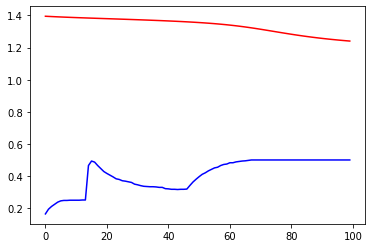

Loss before training 1.395160436630249
Loss after training 1.2405928373336792


In [27]:
fn = FirstNetwork_v1()
fit()

Optim is used for performing optimization methods like GD, NAG, Adam.

In [28]:
from torch import optim

In [29]:
def fit_v1(epochs = 100, learning_rate = 1):
    loss_arr = []
    acc_arr = []
    opt = optim.SGD(fn.parameters(), lr= learning_rate) # Use Stochastic GD for the parameters of the model and given learning rate.

    for epoch in range(epochs):
        y_hat = fn(X_train)         # fn() will execute the forward function in FirstNetwork Class.
        loss = F.cross_entropy(y_hat, Y_train)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, Y_train))
         
        loss.backward()
        opt.step()
        opt.zero_grad()
            
    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

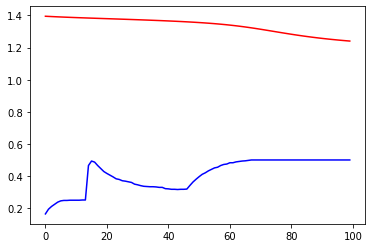

Loss before training 1.395160436630249
Loss after training 1.2405928373336792


In [30]:
fn = FirstNetwork_v1()
fit_v1()

# Using NN.Sequential

Can use Sequential to define the model steps sequentially.

In [31]:
class FirstNetwork_v2(nn.Module):

    def __init__(self):
        super().__init__()       # Calling init function of nn.Module
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(2,2),
            nn.Sigmoid(),
            nn.Linear(2,4),
            nn.Softmax()
        )

    def forward(self, X):
        return self.net(X)

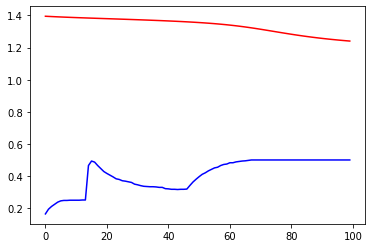

Loss before training 1.395160436630249
Loss after training 1.2405928373336792


In [32]:
fn = FirstNetwork_v2()
fit_v1()

In [33]:
def fit_v2(x, y, model, opt, loss_fn, epochs = 1000):
    
    for epoch in range(epochs):
        loss = loss_fn( model(x), y) # Computing the loss

        loss.backward() 
        opt.step()
        opt.zero_grad()
    
    return loss.item()

In [34]:
fn = FirstNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(), lr=1)
fit_v2(X_train, Y_train, fn, opt, loss_fn)

0.8738410472869873

# Running it on GPUs

In [35]:
device = torch.device("cuda")

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.395159363746643
Time taken 0.7892959117889404


In [36]:
device = torch.device("cuda")

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.395159363746643
Time taken 0.692847490310669


In [37]:
class FirstNetwork_v3(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(2, 1024*4), 
        nn.Sigmoid(), 
        nn.Linear(1024*4, 4), 
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

In [38]:
device = torch.device("cpu")

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v3()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.3890224695205688
Time taken 19.490626335144043


In [39]:
device = torch.device("cuda")

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v3()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.3890228271484375
Time taken 0.7246215343475342
